### Goal: Prototype some QC plots for use with MultiQC

In [ ]:
%%bash

# Collect per-exon read counts from runs of the Dragen pipeline:
mkdir -p data

# From recent runs of the pan-cancer panel on 24 FFPE/Blood samples:
(echo -ne "Chrom\tStart\tEnd\tGene\t" && ls /mnt/pns/vcfs/220301_A01718_0008_BHWVH7DRXY/{SS,D3,CMA_Normal_00,CMA_Normal_01{0,1,2,3,4,5,6}}*/*.target_bed_read_cov_report.bed | cut -f6 -d/ | sed -E 's/-|Twist//g; s/^D3/LCL_/; s/^SS/FFPE_/; s/^CMA_Normal_0/Blood_/' | paste -s) > data/ucla_pancan_exon_covg.txt
ls /mnt/pns/vcfs/220301_A01718_0008_BHWVH7DRXY/{SS,D3,CMA_Normal_00,CMA_Normal_01{0,1,2,3,4,5,6}}*/*.target_bed_read_cov_report.bed | xargs paste | cut -f1-4,$(seq -s, 6 8 190) | tail -n+2 >> data/ucla_pancan_exon_covg.txt

# Make a subset for the 216 genes shared with the 218-gene heme panel:
head -n1 data/ucla_pancan_exon_covg.txt > data/ucla_pancan_exon_covg_heme_genes.txt
grep -wf data/ucla_heme_218.txt data/ucla_pancan_exon_covg.txt >> data/ucla_pancan_exon_covg_heme_genes.txt

# From recent runs of the heme panel on 24 FFPE/Blood samples:
(echo -ne "Chrom\tStart\tEnd\tGene\t" && ls /mnt/pns/vcfs/220426_A01718_0009_AHWVGHDRXY/Heme/*/*.target_bed_read_cov_report.bed | cut -f7 -d/ | perl -pe 's/.*(\d)A$/TwiCap_50_$1/; s/.*(\d)C$/TwiCap_25_$1/; s/.*(\d)B$/IDTCap_50_$1/; s/.*(\d)D$/IDTCap_25_$1/; s/.*(\d)E$/EvoCap_50_$1/; s/.*(\d)F$/EvoCap_100_$1/; ' | paste -s) > data/ucla_heme_exon_covg.txt
ls /mnt/pns/vcfs/220426_A01718_0009_AHWVGHDRXY/Heme/*/*.target_bed_read_cov_report.bed | xargs paste | cut -f1-4,$(seq -s, 6 8 190) | tail -n+2 >> data/ucla_heme_exon_covg.txt

In [1]:
# Load necessary packages and data
import pandas as pd
import plotly.express as px
dfp = pd.read_csv("data/ucla_pancan_exon_covg_heme_genes.txt", sep='\t')
dfh = pd.read_csv("data/ucla_heme_exon_covg.txt", sep='\t')

# Convert read counts to read depth per exon, and then divide that by overall mean to get fold difference
dfp.iloc[:, list(range(4,28))] = dfp.iloc[:, list(range(4,28))].apply(lambda x: 150*x/(dfp.End - dfp.Start))
dfp.iloc[:, list(range(4,28))] = dfp.iloc[:, list(range(4,28))].apply(lambda x: x/x.mean())
dfh.iloc[:, list(range(4,28))] = dfh.iloc[:, list(range(4,28))].apply(lambda x: 150*x/(dfh.End - dfh.Start))
dfh.iloc[:, list(range(4,28))] = dfh.iloc[:, list(range(4,28))].apply(lambda x: x/x.mean())

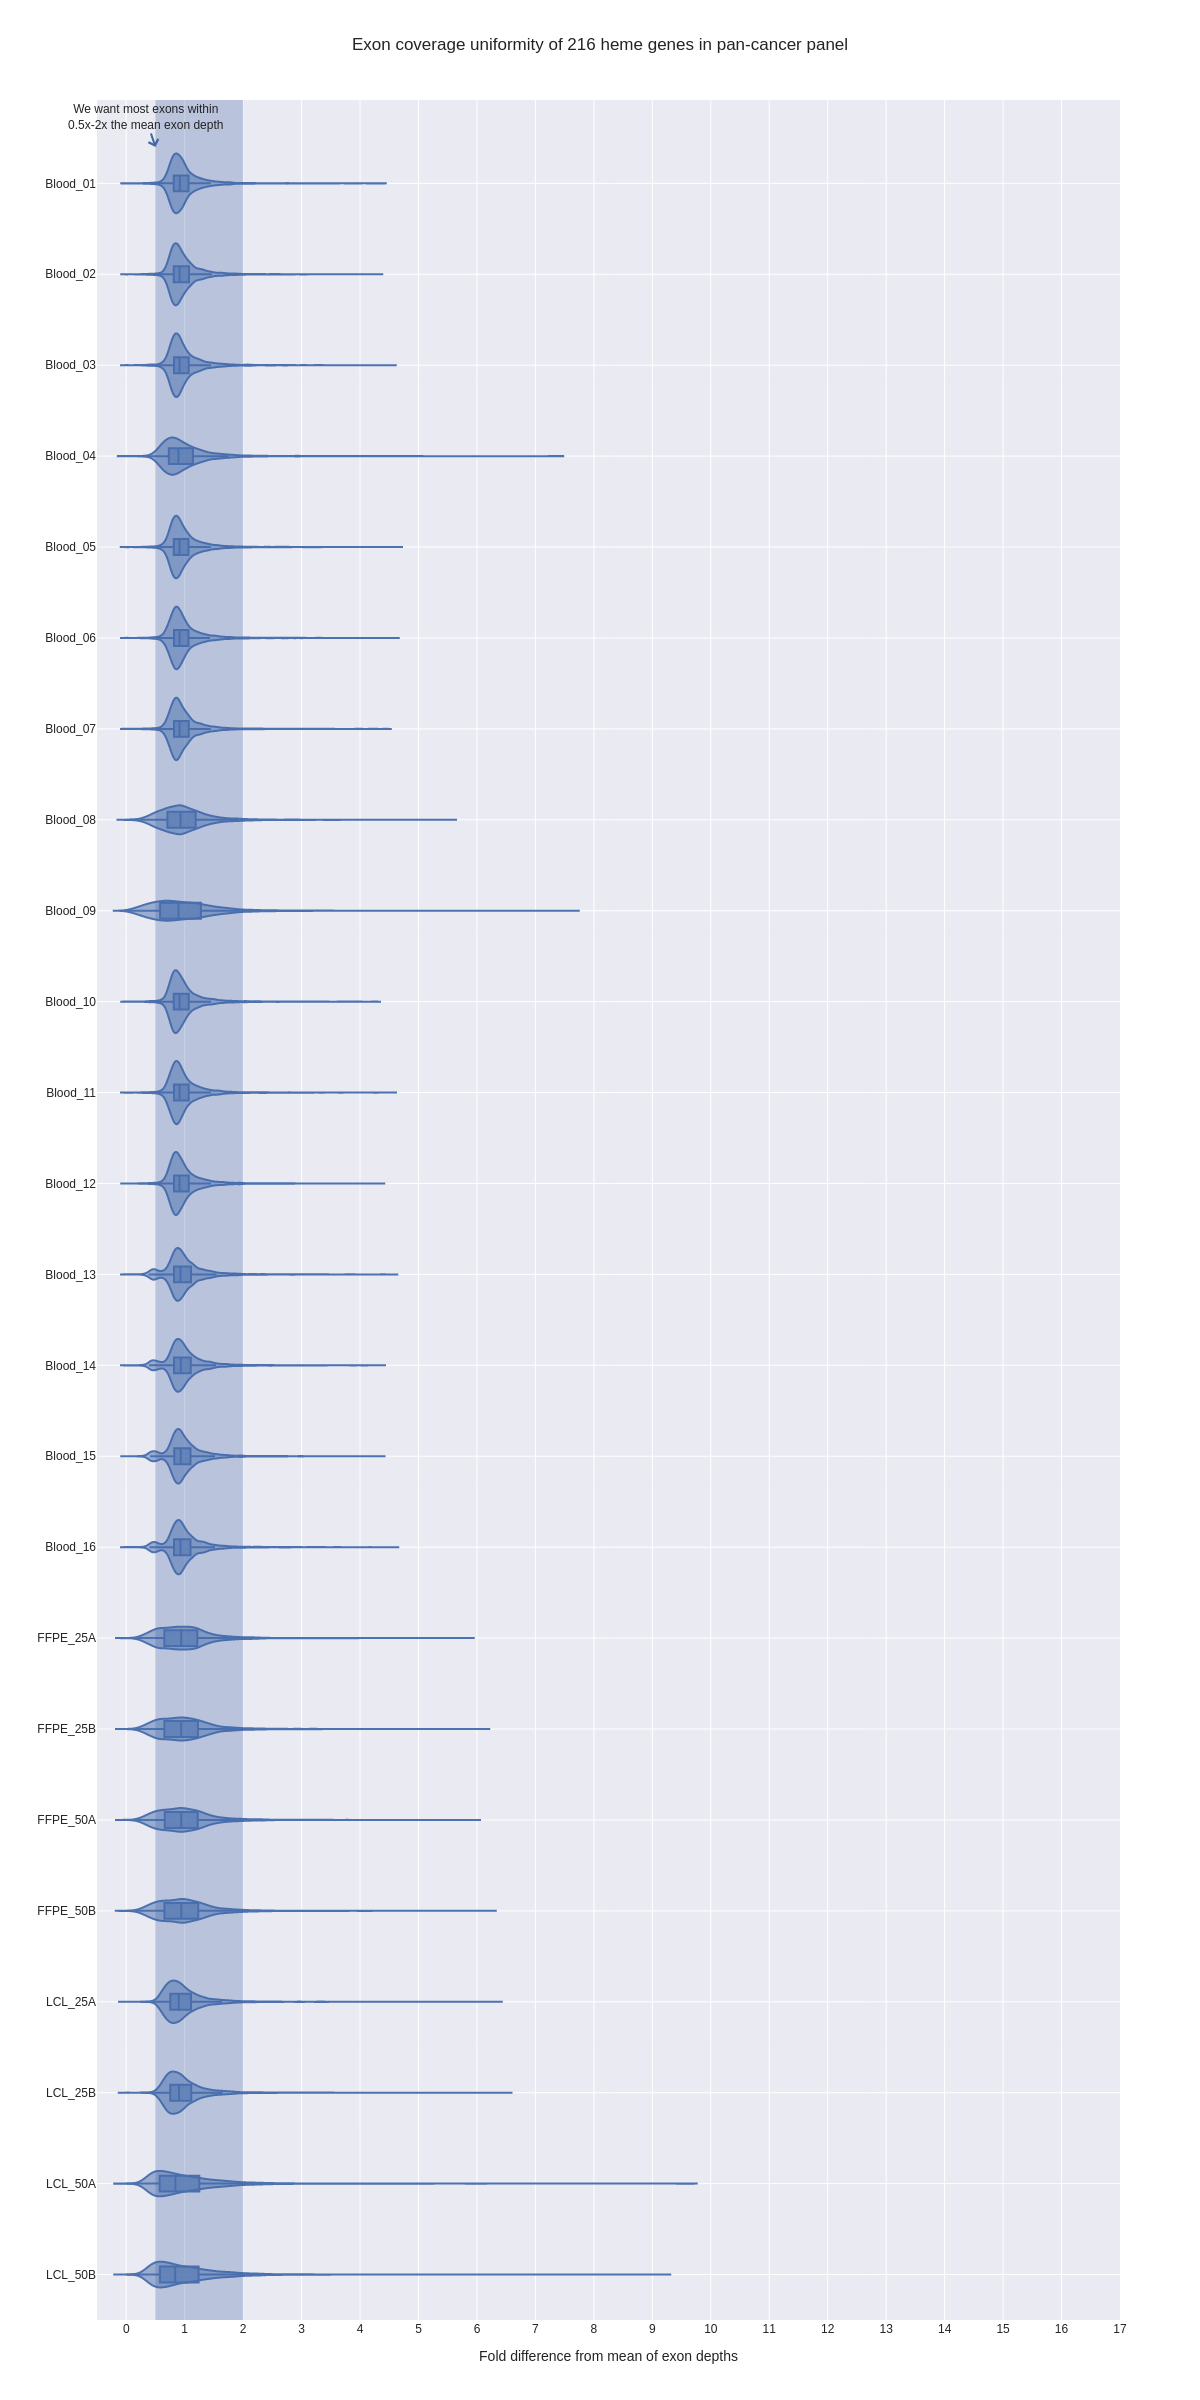

In [5]:
# Make a violin plot for the pan-cancer exons:
fig = px.violin(dfp, x=dfp.columns[list(range(4,28))], range_x=[-0.5,17], title="Exon coverage uniformity of 216 heme genes in pan-cancer panel", labels={"variable": "", "value": "Fold difference from mean of exon depths"}, width=1200, height=2400, template="seaborn", box=True, points=False)
fig.add_vrect(x0=0.5, x1=2, opacity=0.3)
fig.add_annotation(x=0.5, y=23.4, text="We want most exons within<br>0.5x-2x the mean exon depth", showarrow=True, arrowhead=4)
fig.update_layout(violingap=0, xaxis=dict(tickmode='linear', dtick=1), yaxis=dict(categoryorder="category descending"))
fig.show(renderer="png")

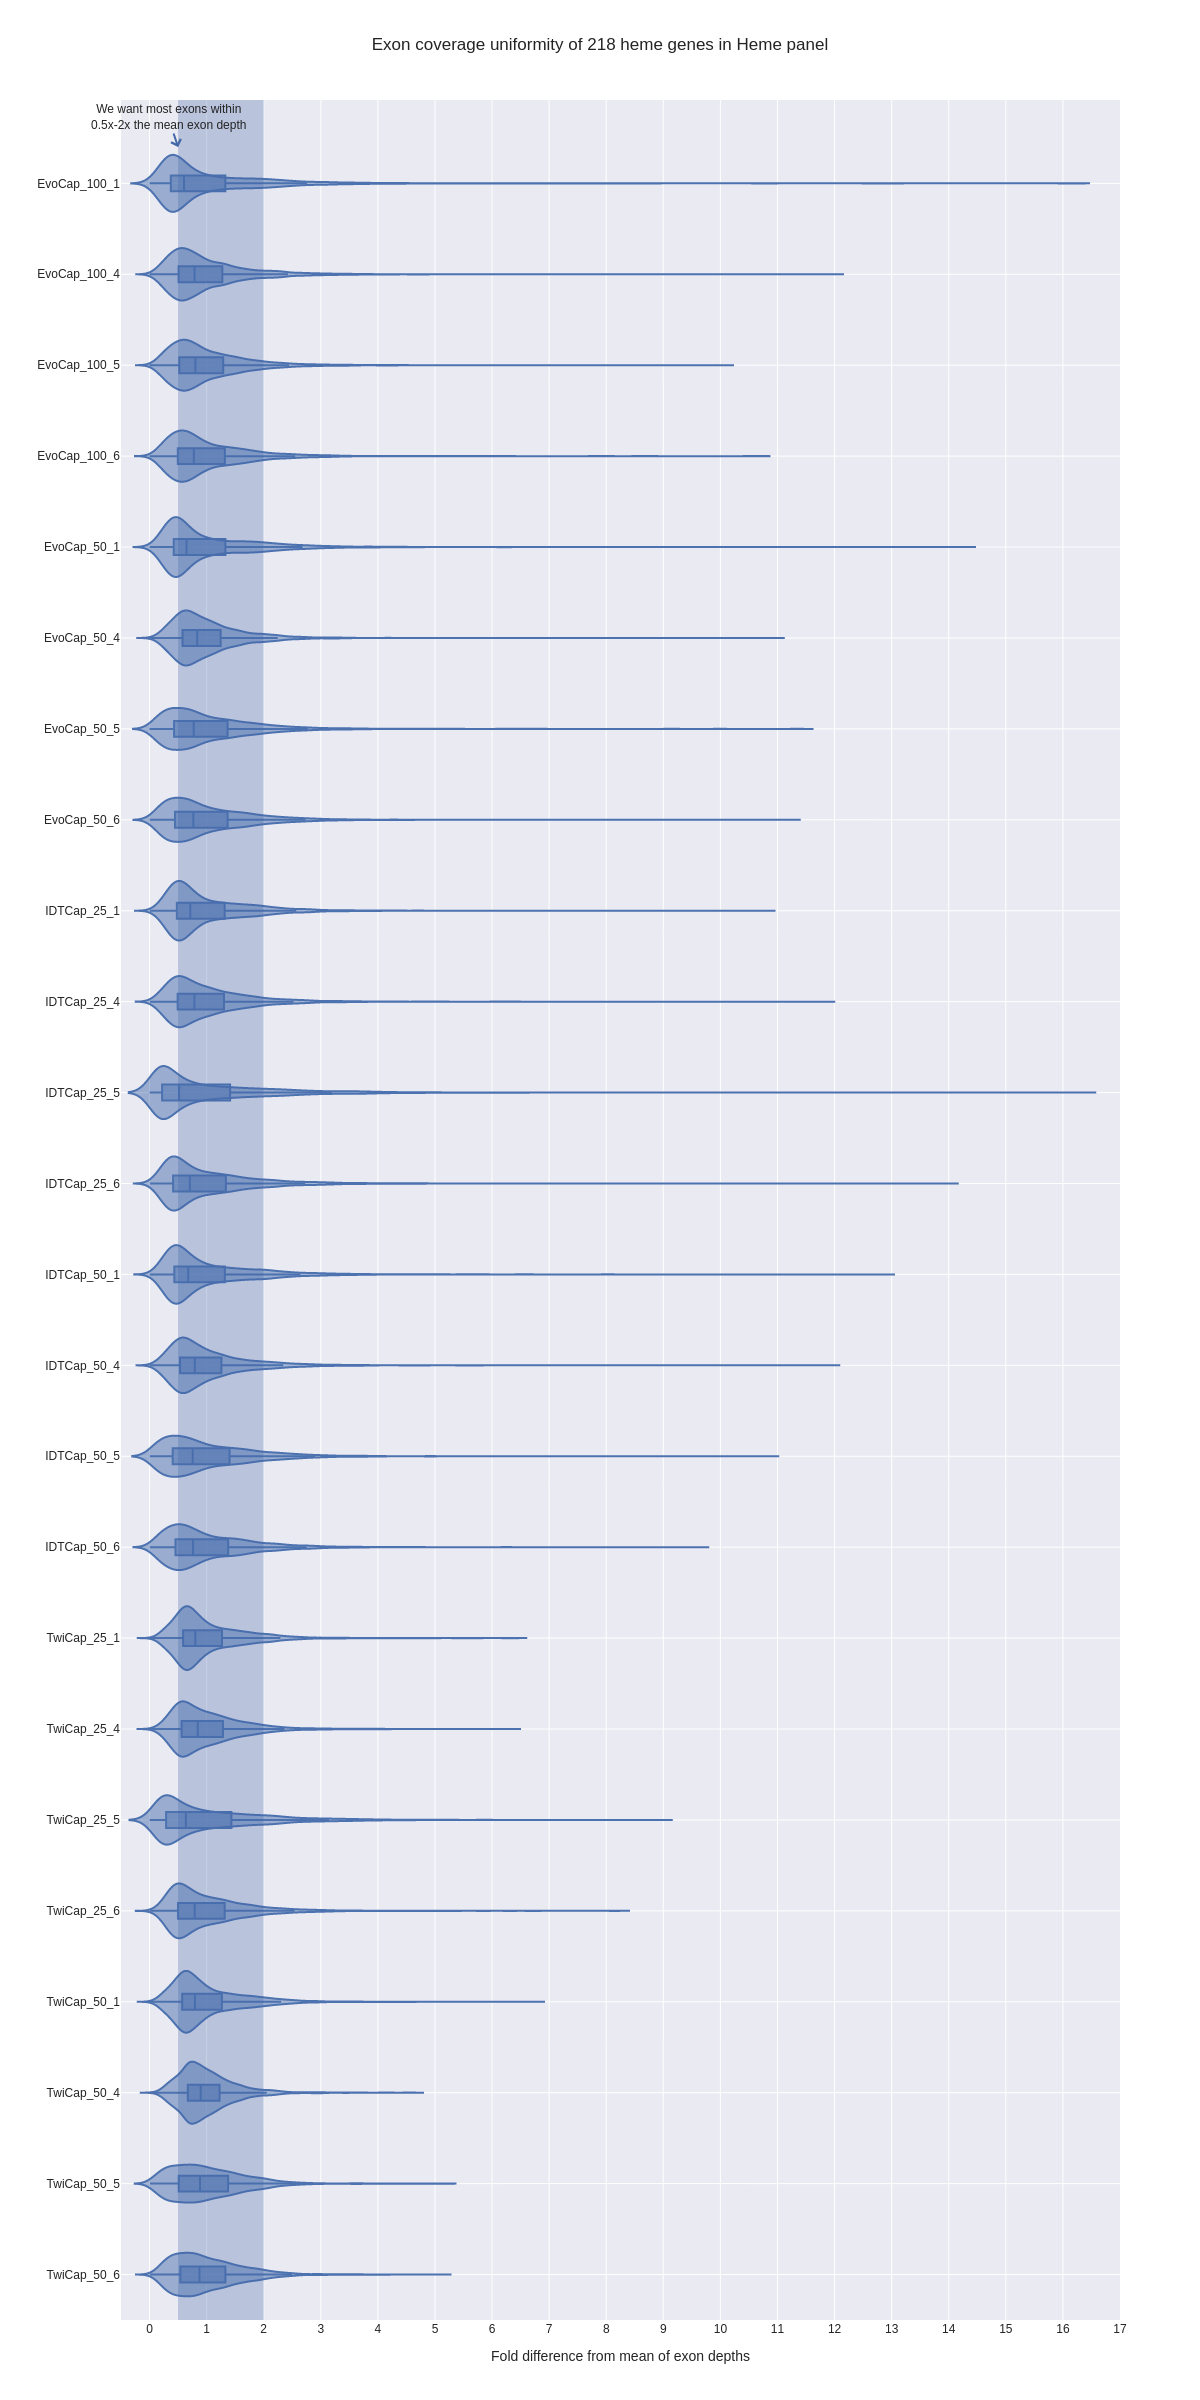

In [6]:
# Make a violin plot for the heme exons:
fig = px.violin(dfh, x=dfh.columns[list(range(4,28))], range_x=[-0.5,17], title="Exon coverage uniformity of 218 heme genes in Heme panel", labels={"variable": "", "value": "Fold difference from mean of exon depths"}, width=1200, height=2400, template="seaborn", box=True, points=False)
fig.add_vrect(x0=0.5, x1=2, opacity=0.3)
fig.add_annotation(x=0.5, y=23.4, text="We want most exons within<br>0.5x-2x the mean exon depth", showarrow=True, arrowhead=4)
fig.update_layout(violingap=0, xaxis=dict(tickmode='linear', dtick=1), yaxis=dict(categoryorder="category descending"))
fig.show(renderer="png")